In [2]:
#coding=utf-8 
import json  #用來讀取/產生 json 格式的套件
import jieba #用來處理中文斷詞的套件
import numpy as np #用來處理數值矩陣的套件

import matplotlib as mpl #用來繪製圖表的套件
import matplotlib.pyplot as plt #為 matplotlib 的子套件，提供命令行式函數的集合
import seaborn as sns #基礎於 matplotlib 的高階圖表的繪製套件


'''sklearn 又名 scikit-learn，為機器學習方法的套件'''

from sklearn.feature_extraction import DictVectorizer #用於轉換 dict 為 sklearn estimators 可用的向量
from sklearn.feature_extraction.text import TfidfTransformer #將矩陣轉換為 TF 或 TF-IDF 表示
from sklearn.svm import LinearSVC #以 LinearSVC 分類演算法為例

from collections import defaultdict #使用 dict 儲存資料

zhfont1 = mpl.font_manager.FontProperties(fname='DejaVuSans.ttf') #讀取中文字型

In [3]:
# load ptt posts

path = 'gossip.json' # 欲載入文檔之路徑

with open(path, encoding='utf8') as f:
    posts = json.load(f)

In [4]:
# get pushes

total_comments = defaultdict(int)
total_pushes = defaultdict(int)
total_hates = defaultdict(int)

for post in posts:
    for comment in post['comments']:
        user = comment['user']
        total_comments[user] += 1

        if comment['score'] > 0:
            total_pushes[user] += 1
        elif comment['score'] < 0:
            total_hates[user] += 1

In [5]:
def show_distributions(counts, pushes, hates):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:20] #取前20個最踴躍回覆者之數據
    usernames = [u for u in sorted_cnts]
    total_y = [counts[u] for u in sorted_cnts]
    y_pushes = [pushes[u] for u in sorted_cnts]
    y_hates = [hates[u] for u in sorted_cnts]
    y_neutral = np.asarray(total_y) - np.asarray(y_pushes) - np.asarray(y_hates) #取得箭頭(中立)之留言數
    y_NandP = y_neutral + np.asarray(y_pushes)

    X = np.arange(20)
    fig, ax = plt.subplots(figsize=(10,8))

    plt.bar(X, np.asarray(y_pushes)+np.asarray(y_neutral), facecolor='#00ACC1', edgecolor='white')
    plt.bar(X, np.asarray(y_neutral), facecolor='#7CB342', edgecolor='white')
    plt.bar(X, -np.asarray(y_hates), facecolor='#FFB300', edgecolor='white')
    plt.xlim(-0.5, 19.5)

    ax.set_xticks(X)
    ax.set_xticklabels(usernames, rotation=45, fontsize=10, fontdict={'fontname': 'DejaVu Sans', 'fontsize':10})
    plt.ylim(-max(y_hates)*1.2, max(y_NandP)*1.2)
    plt.yticks(())
    
    for x,y,z in zip(X, np.asarray(y_pushes)+np.asarray(y_neutral), np.asarray(y_pushes)):
        plt.text(x, y+10, z, ha='center', va='bottom')

    for x,y in zip(X, np.asarray(y_neutral)):
        plt.text(x, y-35, y, ha='center', va='bottom')

    for x,y in zip(X, -np.asarray(y_hates)):
        plt.text(x, y-35, abs(y), ha='center', va='bottom')
    
    plt.show(fig)

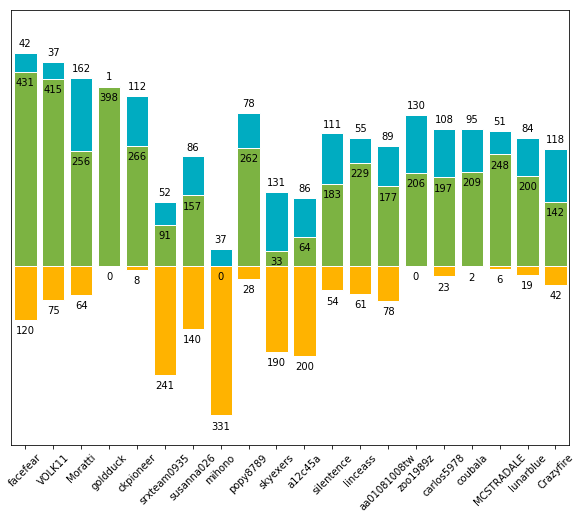

In [6]:
# display the distributions of top 20 users' comments
show_distributions(total_comments, total_pushes, total_hates)

In [7]:
# grap comments

c_words = []
c_scores = []

for post in posts:
    for comment in post['comments']: #取得八卦文文章之鄉民留言
        l = comment['content'].strip() #去頭去尾換行之類的字符
        if l and comment['score'] != 0:
            d = defaultdict(int)
            for w in jieba.cut(l): # w 是針對 l 中的文字斷詞後所得之詞語
                d[w] += 1
            if len(d) > 0:
                c_scores.append(1 if comment['score'] > 0 else 0) #每一則留言之標記(推/噓)
                c_words.append(d)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 0.795 seconds.
Prefix dict has been built succesfully.


In [8]:
# convert to vectors
c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_vector = c_dvec.fit_transform(c_words)
c_X = c_tfidf.fit_transform(c_vector) #將一千篇所有鄉民留言的斷詞文字矩陣轉成向量並計算tf-idf

In [9]:
# build and train the classifier
c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [10]:
def display_top_features(weights, names, top_n, select=abs): # 取得負面就將 select 設為絕對值函式
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n] #遞減
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')

    width = 0.30
    ax.set_xticks(ind + width)
    ax.set_xticklabels(top_names, rotation=45, fontsize=12, fontproperties=zhfont1)
    plt.show(fig)

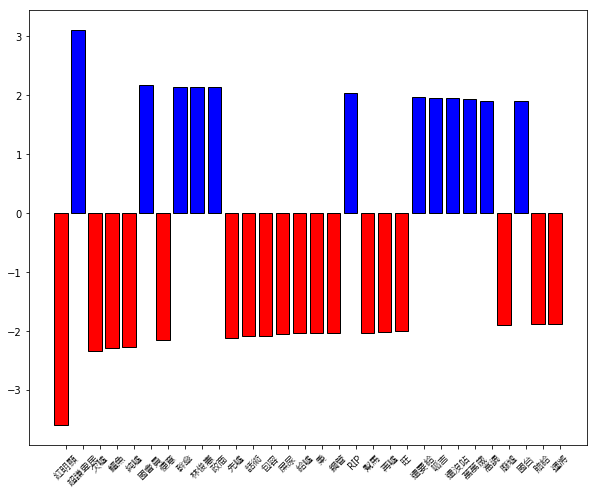

In [11]:
# SVC - top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)

In [12]:
#分類留言的情緒
def comment_sentiment_classifier(model, dvec, tfidf, text):
    l = text.strip() #去頭去尾換行之類的字符
    d = defaultdict(int)

    for w in jieba.cut(l): # w 是針對 l 中的文字斷詞後所得之詞語
        d[w] += 1

    comment_vec = dvec.transform(d)
    comment_X = tfidf.transform(comment_vec)
    result = model.predict(comment_X)
    
    if result == 1:
        print(text,'---感覺還不錯哦！')
    else:
        print(text,'---你很不開心喔？')

In [ ]:
while (1):
    s = input('輸入留言！偵測你的情緒狀態：')
    if s == '-1':
        print('掰掰！歡迎再來玩！')
        break
    else:
        comment_sentiment_classifier(c_svc, c_dvec, c_tfidf, s)

輸入留言！偵測你的情緒狀態：罪有英德
罪有英德 ---你很不開心喔？
輸入留言！偵測你的情緒狀態：賴清德
賴清德 ---你很不開心喔？
輸入留言！偵測你的情緒狀態：蔡英文
蔡英文 ---感覺還不錯哦！
輸入留言！偵測你的情緒狀態：勞動部
勞動部 ---你很不開心喔？
輸入留言！偵測你的情緒狀態：勞基法
勞基法 ---你很不開心喔？
輸入留言！偵測你的情緒狀態：健保
健保 ---你很不開心喔？
